In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import random
import keras
from matplotlib import pyplot as plt
import numpy as np
from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from keras import optimizers
from keras.utils import multi_gpu_model
from keras import backend as K
from SSD_loss import SSDLoss
from importlib import reload
import cv2
import pet_data
import nets
import tensorflow as tf
from pet_detector_help import *
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
input_H = 224
input_W = 224
input_C = 3
input_shape = (input_H, input_W, input_C)
data_root = "/home/cai/dataset/pets/"
extras =  ['S', 512 ]
feature_map = [7,7,4,4,2,1]
aspect_ratios = [[2,3],[2,3],[2,3],[2,3],[2],[2]] 
mbox =  [2 + len(ar) * 2 for ar in aspect_ratios]  # number of boxes per feature map location
source_layers=["out_relu"]

In [4]:
annot = data_root + "annotations"

In [6]:
def generate_class_names(annot):
    list_names = open(annot + '/trainval.txt').readlines()
    class_names = []
    for name in list_names:
        name = name.lower()
        p = name.rfind('_')
        if not name[:p] in class_names:
            class_names.append(name[:p])
    print(class_names)
    file = open(os.path.join(annot,'class_names.txt'),'w')
    file.writelines([name + "\n" for name in class_names ])
generate_class_names(annot)

['abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


## Read classnames

In [7]:
#read_class_names(annot):
file = open(os.path.join(annot,'class_names.txt'))
lines = open(os.path.join(annot,'class_names.txt')).readlines()
class_names = [name[:-1] for name in lines]
num_classes = len(class_names)
print(class_names)
print('classes num',num_classes)

['abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
classes num 37


## Split annotations

In [8]:
import pet_data
reload(pet_data)
pet_data.split_annotations(data_root,'trainval.txt')

before ignore: 3680
after ignore: 3671


## Load Dataset

In [11]:
(x_train,y_train_no_process),(x_test,y_test_no_process) = pet_data.load_data(0.25,0.25,root=data_root,task = 'detection')
print("x_train shape",x_train.shape," y_train_no_process shape",y_train_no_process.shape)
print("x_test shape",x_test.shape," y_test_no_process shape",y_test_no_process.shape)

..........done
x_train shape (688, 224, 224, 3)  y_train_no_process shape (688, 41)
x_test shape (229, 224, 224, 3)  y_test_no_process shape (229, 41)


## Generate prior boxes and process y

In [13]:
y_train = y_train_no_process.copy()
y_test = y_test_no_process.copy()
#print(y_train.shape,y_test.shape)
#print(y_train[:,0])

## Draw a sample of y_true

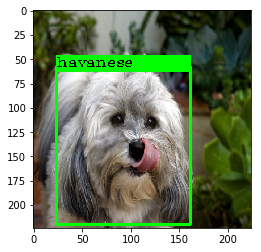

In [15]:
import pet_detector_help
reload(pet_detector_help)
from pet_detector_help import *
x = x_train[0].copy()
y = y_train_no_process[0].copy()
#print(y_train_no_process[:,1])
frame= (x * 255).astype('int32')
draw_detection(frame,y,class_names,box_color=(0,255,0),font_scale =0.5,draw_label=True)
plt.imshow(frame)
plt.show()

### Load a base model

In [ ]:
base_model =  keras.applications.mobilenet_v2.MobileNetV2(input_shape=(input_H,input_W,input_C), alpha=1.0, depth_multiplier=1, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)

 1327104/14536120 [=>............................] - ETA: 2:51

In [ ]:
base_model.summary()

### Set hyper params

In [ ]:
reload(nets)
build_model = nets.build_simple_detection_net
#Train
phase = 'training' #training or testing
epochs_per_stage = 30
stages = 5
batch_size = 16
verbose = 1
use_data_augment = False
plot = True
#Environment
#clear_session = True
#Learning params
lr=5e-4
decay=1e-6
momentum=0.9

In [ ]:
validation_split = 0.25
load_weights = False
check_point = 1
save_path = 'saved_weights'

In [ ]:
if phase!='testing' and phase!='training':
    raise RuntimeError("Phase must be either testing or training")
if epochs_per_stage < 1:
    raise RuntimeError("Epochs per stage must be greater than 1")
if stages < 1:
    raise RuntimeError("Stages must be greater than 1")
if phase == 'testing' and load_weights != True:
    print("Warning: phase is testing and load weights is not True")
if phase == 'training' and load_weights == False and check_point != 1:
    print("Warning: Initial check point should be 1")
    check_point = 1
    

In [ ]:
def Loss(y_true,y_pred):
    log_loss = -tf.reduce_mean(tf.reduce_sum(y_true[:,:-4] * tf.log(y_pred[:,:-4]), axis=-1))
    mse_loss = tf.reduce_sum(tf.square(y_true[:,-4:] - y_pred[:,-4:]))
    total_loss = log_loss + mse_loss
    return total_loss

### Build model with a backbone

In [ ]:
#loss = SSDLoss().compute_loss
loss = Loss
model_name,model = build_model(base_model,"out_relu",num_classes)
model.compile(loss=loss,optimizer=optimizers.SGD(lr=lr,decay=decay,momentum=momentum))
#model.summary()
print(model_name,'has been built ')

#### Check y train、y_test and output of model should have the same shape

In [61]:
print(model.output.get_shape(),y_train.shape)
assert((np.array(model.output.get_shape().as_list()[1:]) == np.array(y_train.shape[1:])).all())
assert((np.array(model.output.get_shape().as_list()[1:]) == np.array(y_test.shape[1:])).all())

(?, 41) (688, 41)


In [62]:
print(model.output.get_shape())
print(y_train.shape)

(?, 41)
(688, 41)


## Load weights

In [63]:
if load_weights:
    model.load_weights(save_path + '/' + model_name + '_' + str(check_point) + ".h5")
    print("weights loaded from check point",check_point)
    if phase == 'training':
        check_point += 1

## Training or testing

In [64]:
if phase == 'training':
    print('model name',model_name)
    print('start fitting.. ','\nstages:',stages,' epochs_per_stage:',epochs_per_stage,' plot history:',plot)
    print('learning rate:',lr,' decay:',decay,' momentum:',momentum)
    print('initial checkpoint:',check_point)
    print('load weight:',load_weights)
    for i in range(1,1+stages):
        print("stage ",i,"of",stages)
        history = model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs_per_stage, verbose = verbose, validation_split = validation_split)
        #fit_generator(model,x_train,y_train)
        path = save_path + '/' + model_name + '_' + str(check_point) + ".h5"
        print("save at",path)
        model.save_weights(path)
        check_point += 1 
        evaluate(model,x_test,y_test)
        if plot:
            plot_history(history)
elif phase =='testing':
    print('start evaluating')
    result = model.evaluate(x=x_test,y=y_test)
    print('loss',round(result,5))
    evaluate(model,x_test,y_test)
   # model.save_weights(model_name + ".h5")

model name simple_detection_net_37_out_relu
start fitting..  
stages: 5  epochs_per_stage: 30  plot history: True
learning rate: 0.0005  decay: 1e-06  momentum: 0.9
initial checkpoint: 1
load weight: False
stage  1 of 5
Train on 516 samples, validate on 172 samples
Epoch 1/30
516/516 [==============================] - 18s 36ms/step - loss: 7.2127 - val_loss: 7.0136
Epoch 2/30
516/516 [==============================] - 8s 16ms/step - loss: 6.7262 - val_loss: 6.9659
Epoch 3/30
516/516 [==============================] - 8s 16ms/step - loss: 6.8048 - val_loss: 7.0274
Epoch 4/30
516/516 [==============================] - 8s 16ms/step - loss: 6.8923 - val_loss: 7.0266
Epoch 5/30
516/516 [==============================] - 8s 16ms/step - loss: 6.7184 - val_loss: 6.8654
Epoch 6/30
516/516 [==============================] - 8s 16ms/step - loss: 6.7069 - val_loss: 6.6876
Epoch 7/30
516/516 [==============================] - 8s 16ms/step - loss: 6.5460 - val_loss: 6.8645
Epoch 8/30
516/516 [======

NameError: name 'plt' is not defined

*Set hyper params and run all above from here*


#### Select a test image and do the prediction

In [414]:
cats_idx = np.where(y_test[:,0] == 1)[0]
test_idx = [0,1,2,3,4,5,6,7,100,101,102,200,201]
x = x_test
y = y_test
y_pred_no_process = model.predict(x[test_idx])
y_pred = y_pred_no_process.copy()
#print(y_pred)
#y_pred = post_process(y_pred_no_process,priors,iou_thresh=0.01,score_thresh=0.01)
#print(np.where(y_pred_no_process[:,:,1]>0.1))

In [411]:
for k,prediction  in enumerate(y_pred):
    #print(prediction)
    # Extract x from test set
    print("image: ",k)
    frame = (test_set[0][test_idx[k]]*255).astype('int32')
    for c,detections in enumerate(prediction):
        if len(detections) == 0:
            continue
        class_name = class_names[c]
        for detection in detections:
            score = detection[0]
            bbox = detection[1:] * input_H#corner
            print(class_name,score,bbox)
            bbox = bbox.astype('int32')
            draw_detection(frame,bbox,score,class_name,box_width = 3)
    plt.imshow(frame)
    plt.show()

image:  0


TypeError: object of type 'numpy.float32' has no len()

image:  0
prediction [0.00199289 0.9979583  0.29005113 0.13207479 0.6680361  0.6192616 ]
truth [0.         1.         0.32333333 0.14925373 0.70333333 0.6318408 ]


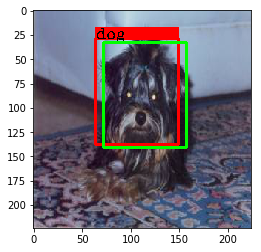

image:  1
prediction [0.00522468 0.9978582  0.08383311 0.10185324 0.3440894  0.6050769 ]
truth [0.         1.         0.082      0.15915916 0.326      0.6036036 ]


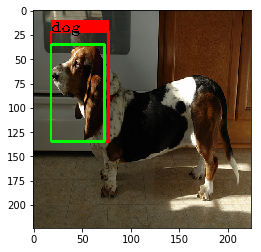

image:  2
prediction [0.00131881 0.9980311  0.36190996 0.04489107 0.77540964 0.438725  ]
truth [0.         1.         0.32934132 0.054      0.73353293 0.45      ]


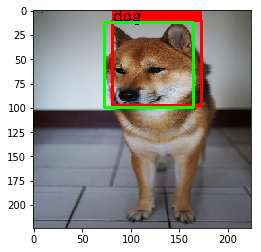

image:  3
prediction [0.998662   0.0013213  0.30057657 0.24422212 0.8936486  0.5419076 ]
truth [1.         0.         0.27027027 0.194      0.87687688 0.562     ]


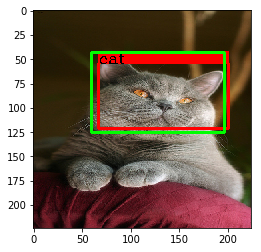

image:  4
prediction [0.00230399 0.99819773 0.19955276 0.02775864 0.65900654 0.8862287 ]
truth [0.         1.         0.198      0.003003   0.658      0.87387387]


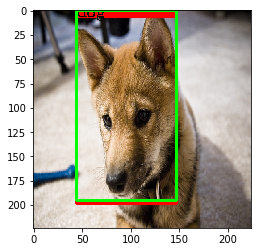

image:  5
prediction [9.9903500e-01 7.9972425e-04 3.4706435e-01 1.5475494e-01 6.9503140e-01
 6.3933772e-01]
truth [1.         0.         0.38       0.13213213 0.69       0.58858859]


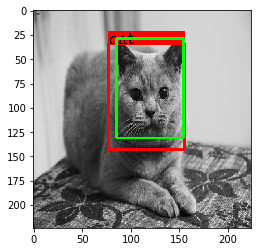

image:  6
prediction [0.9986387  0.00100955 0.17397344 0.24096787 0.6930095  0.8074672 ]
truth [1.         0.         0.25       0.21257485 0.708      0.83832335]


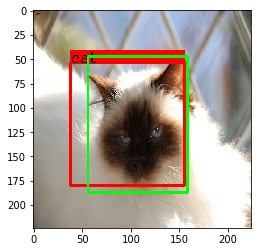

image:  7
prediction [9.9974698e-01 3.3046637e-04 1.7209952e-01 7.6753020e-02 5.5779821e-01
 7.6359701e-01]
truth [1.         0.         0.176      0.06906907 0.57       0.72672673]


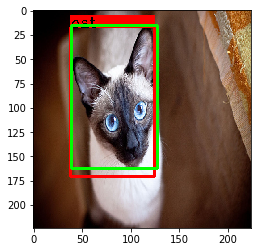

image:  8
prediction [0.00144601 0.99819463 0.40178165 0.09610631 0.897398   0.85503596]
truth [0.         1.         0.354      0.11111111 0.844      0.84084084]


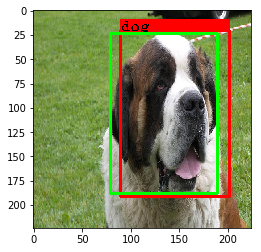

image:  9
prediction [0.0912063  0.7768828  0.20226303 0.08967321 0.6472403  0.51601684]
truth [1.         0.         0.34933333 0.084      0.72       0.448     ]


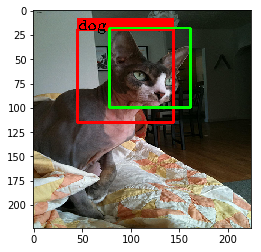

image:  10
prediction [0.9975435  0.00267319 0.14492266 0.16121598 0.7445335  0.6884378 ]
truth [1.         0.         0.15733333 0.094      0.664      0.47      ]


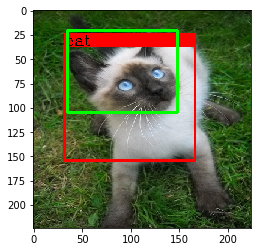

image:  11
prediction [0.00469757 0.9946504  0.29656798 0.22873682 0.74667    0.59483606]
truth [0.         1.         0.28211587 0.288      0.73551637 0.63      ]


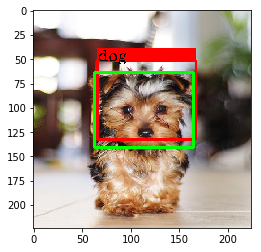

image:  12
prediction [1.6799984e-04 9.9990237e-01 3.4393224e-01 2.4773212e-01 6.6394055e-01
 6.4186144e-01]
truth [0.         1.         0.35       0.26470588 0.638      0.61764706]


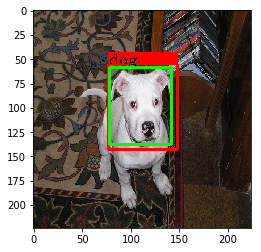

In [415]:
for k,prediction  in enumerate(y_pred):
    #print(prediction)
    # Extract x from test set
    print("image: ",k)
    frame = (x[test_idx[k]] * 255).astype('int32')
    print('prediction',prediction)
    draw_detection(frame,prediction,class_names)
    print('truth',y[test_idx[k]])
    draw_detection(frame,y[test_idx[k]],class_names,box_color = (0,255,0),draw_label = True)
    plt.imshow(frame)
    plt.show()

(754, 835, 3)
[0.83112806 0.14010227 0.34534693 0.1068016  0.73249453 0.367809  ]
(754, 835, 3)
[288.3647    80.528404 611.63293  277.32797 ]


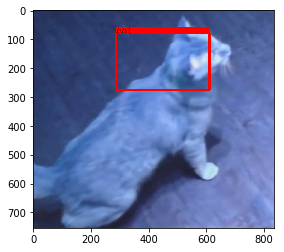

In [489]:
img_file = "data/cat1.png"
img = cv2.imread(img_file)
print(img.shape)
x = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = np.array(x,dtype='float')
x = x / 255
y_pred = model.predict(np.expand_dims(x,0))[0]
print(y_pred)
draw_detection(img,y_pred,class_names,box_width=5,font_scale=1)
plt.imshow(img)

Input Video Size: (1280, 720)  Fps: 29.97002997002997  Frames: 1585


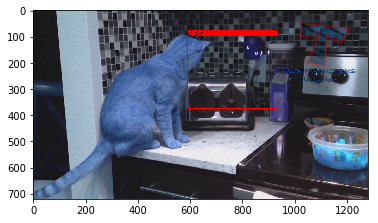

.

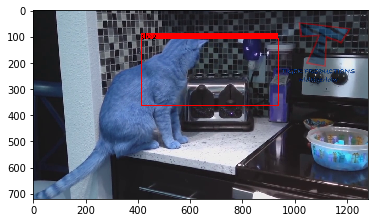

.

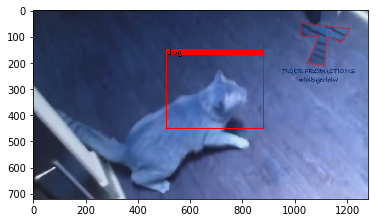

.

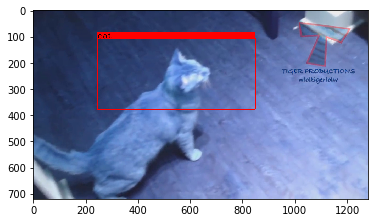

.

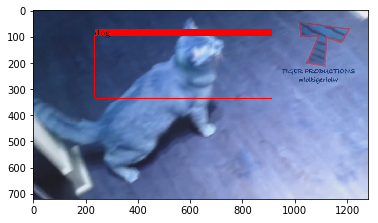

.

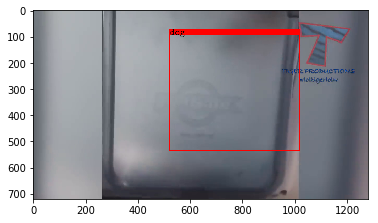

.

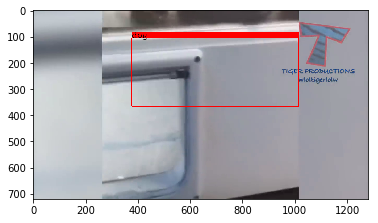

.

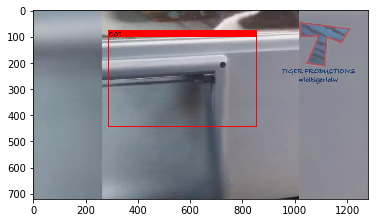

.

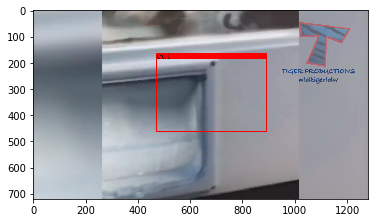

.

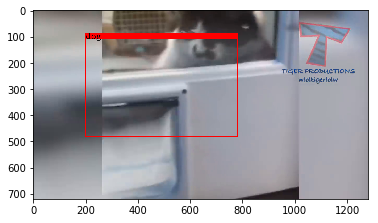

.

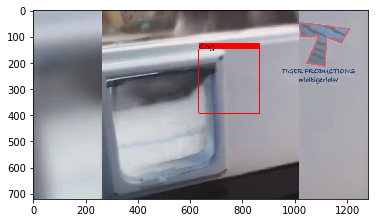

.

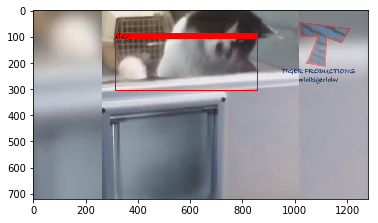

.

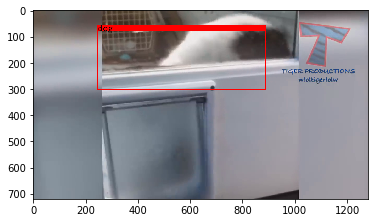

.

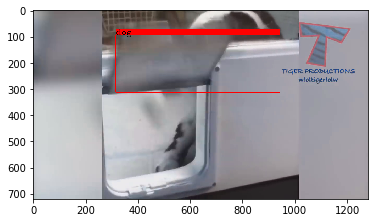

.

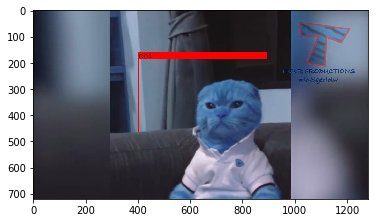

.

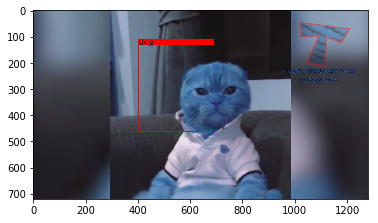

.

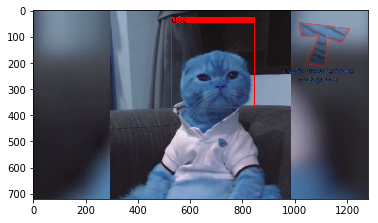

.

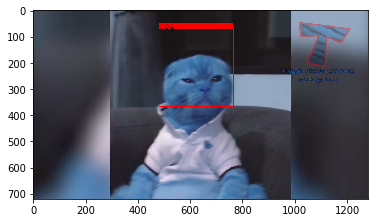

.

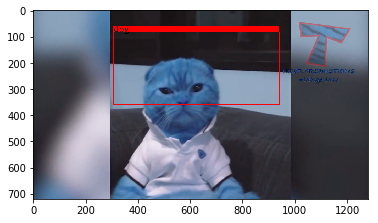

.

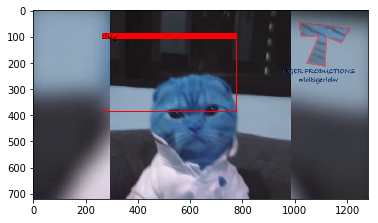

.

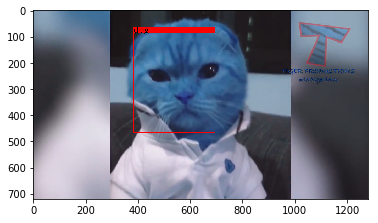

.

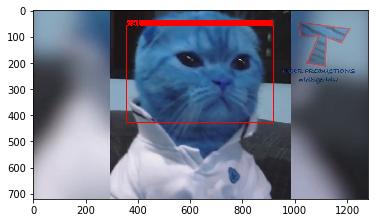

.

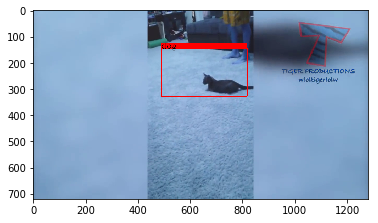

.

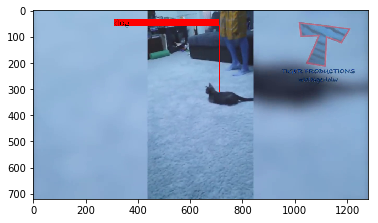

.

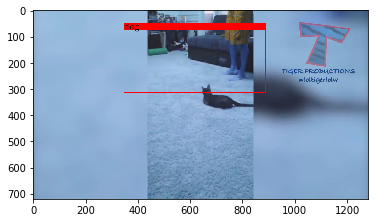

.

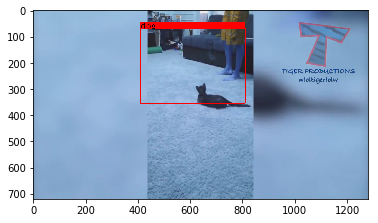

.

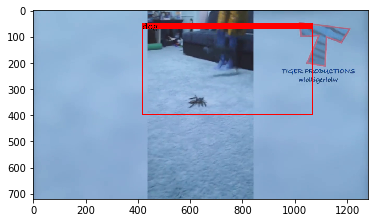

.

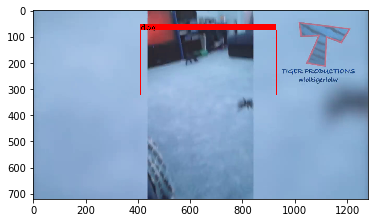

.

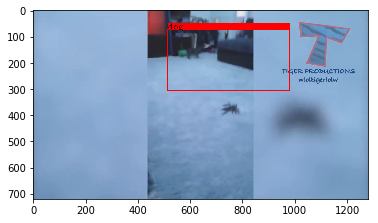

.

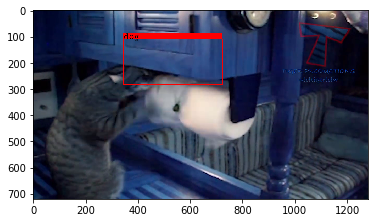

.done


In [492]:
video_file = "data/cats_video.mp4"
result_file = "res.avi"
cap= cv2.VideoCapture(video_file)
fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
frames = (int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print('Input Video Size:',size,' Fps:',fps,' Frames:',frames)
writer = cv2.VideoWriter(result_file,cv2.VideoWriter_fourcc(*'MJPG'), fps, size)
success,frame = cap.read()
count = 1
while success:
    x = cv2.resize(frame,dsize=(input_H,input_W),interpolation=cv2.INTER_CUBIC)
    x = x / 255
    y_pred = model.predict(np.expand_dims(x,0))[0]
    draw_detection(frame, y_pred,class_names,font_scale = 1)
    writer.write(frame)
    cv2.waitKey(1)
    count += 1
    if count%50==0:
        plt.imshow(frame)
        plt.show()
        print('.',end='')
    success,frame = cap.read()
print('done')